In [1]:
# Ali Babolhaveji
# Selective Search

import os 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import scipy.misc 
import skimage.segmentation
import skimage.feature
from copy import copy


/home/ali/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
## This must be the location of the PASCAL VOC data. 
img_dir          = "/home/ali/VOCdevkit/VOC2012_1500/JPEGImages"

/home/ali/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


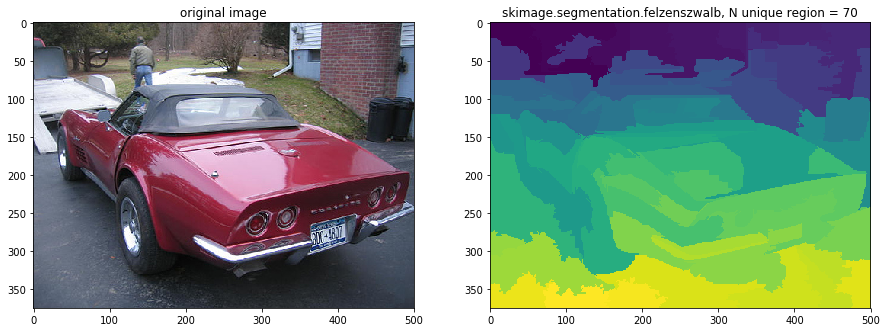

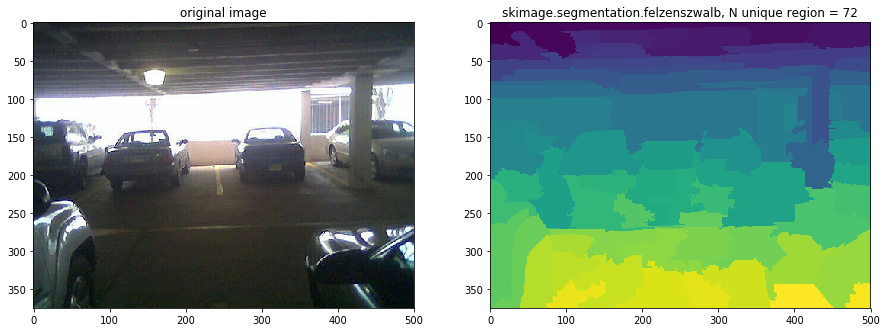

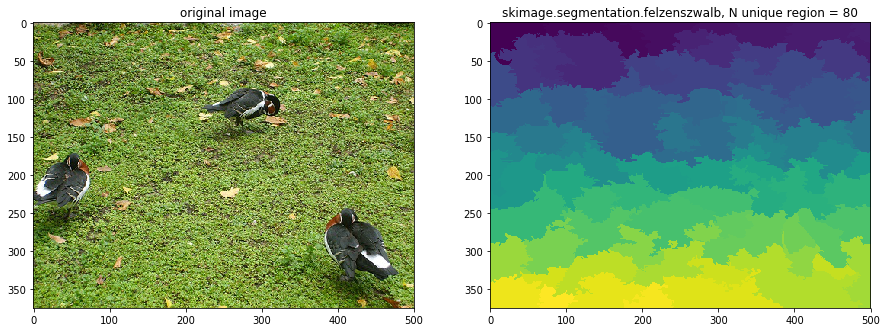

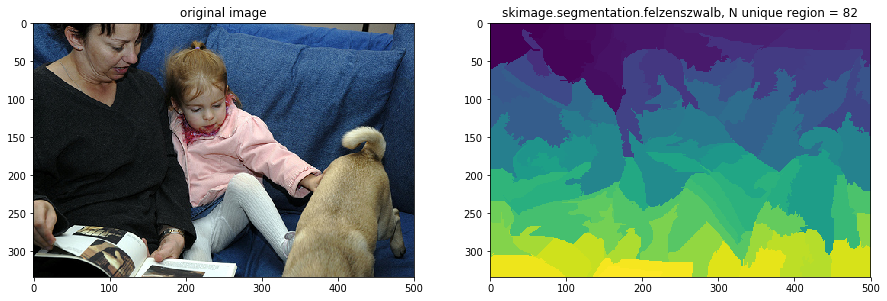

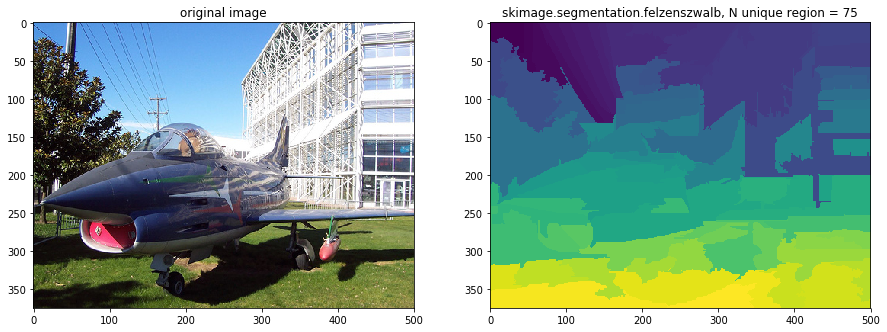

In [3]:
def image_segmentation(img_8bit, scale = 1.0, sigma = 0.8, min_size = 50):
    '''
    J.R.R. Uijlings's hierarchical grouping algorithm 
    
    == input ==
    img_8bit : shape = (height, width, 3),
               8-bits degital image (each digit ranges between 0 - 255)
    
    == output ==
    img      : shape = (height, width, 4)
    '''
    # convert the image to range between 0 and 1
    img_float = skimage.util.img_as_float(img_8bit)
    im_mask   = skimage.segmentation.felzenszwalb(
                    img_float, 
                    scale    = scale, 
                    sigma    = sigma,
                    min_size = min_size)
    img       = np.dstack([img_8bit,im_mask])
    return(img)

scale    = 1.0
sigma    = 0.8
# min_size may be around 50 for better RCNN performance but for the sake of visualization, I will stick to min_size =500
min_size = 500 # 500 3000

np.random.seed(4)
listed_path = os.listdir(img_dir)
Nplot = 5
random_img_path = np.random.choice(listed_path,Nplot)
for imgnm in random_img_path:
    # import 8 bits degital image (each digit ranges between 0 - 255)
    img_8bit  = scipy.misc.imread(os.path.join(img_dir,imgnm))
    img       = image_segmentation(img_8bit, scale, sigma, min_size)
    
    fig = plt.figure(figsize=(15,30))
    ax  = fig.add_subplot(1,2,1)
    ax.imshow(img_8bit)
    ax.set_title("original image")
    ax  = fig.add_subplot(1,2,2)
    ax.imshow(img[:,:,3])
    ax.set_title("skimage.segmentation.felzenszwalb, N unique region = {}".format(len(np.unique(img[:,:,3]))))
    plt.show()

In [4]:
def extract_region(img):
    '''
    For each segmented region,
    extract smallest rectangle regions covering the smallest segmented region.
    
    == input ==
    img : (height, width, N channel)
          N channel = [R, G, B , L], L = label for the region
          only the L channel is used in this analysis 
    == output ==
    
    dictionary R :
    
    {0: {'labels': [0], 'max_x': 131, 'max_y': 74, 'min_x': 0,   'min_y': 0},
     1: {'labels': [1], 'max_x': 189, 'max_y': 37, 'min_x': 75,  'min_y': 0},
     2: {'labels': [2], 'max_x': 282, 'max_y': 38, 'min_x': 162, 'min_y': 0},
     3: {'labels': [3], 'max_x': 499, 'max_y': 23, 'min_x': 247, 'min_y': 0},
     4: {'labels': [4], 'max_x': 499, 'max_y': 74, 'min_x': 428, 'min_y': 13},
     5: {'labels': [5], 'max_x': 441, 'max_y': 76, 'min_x': 333, 'min_y': 16},
     6: {'labels': [6], 'max_x': 348, 'max_y': 80, 'min_x': 62,  'min_y': 21},
    '''
    ## only use the segmentation output
    img_segment = img[:,:,3]
    R = {}
    for y, i in enumerate(img_segment): ## along vertical axis 

        for x, l in enumerate(i): ## along horizontal axis
            # initialize a new region
            if l not in R:
                R[l] = {"min_x": np.Inf, 
                        "min_y": np.Inf,
                        "max_x": 0, 
                        "max_y": 0, 
                        "labels": [l]}

            # bounding box
            if R[l]["min_x"] > x:
                R[l]["min_x"] = x
            if R[l]["min_y"] > y:
                R[l]["min_y"] = y
            if R[l]["max_x"] < x:
                R[l]["max_x"] = x
            if R[l]["max_y"] < y:
                R[l]["max_y"] = y
    ## remove region if it does not have positive height or positive width
    
    Rcopy = copy(R)
    for key in R.keys():
        r = R[key]
        if (r["min_x"] == r["max_x"]) or (r["min_y"] == r["max_y"]):
            del Rcopy[key]
    return(Rcopy)
R = extract_region(img)
print("{} rectangle regions are found".format(len(R)))

75 rectangle regions are found


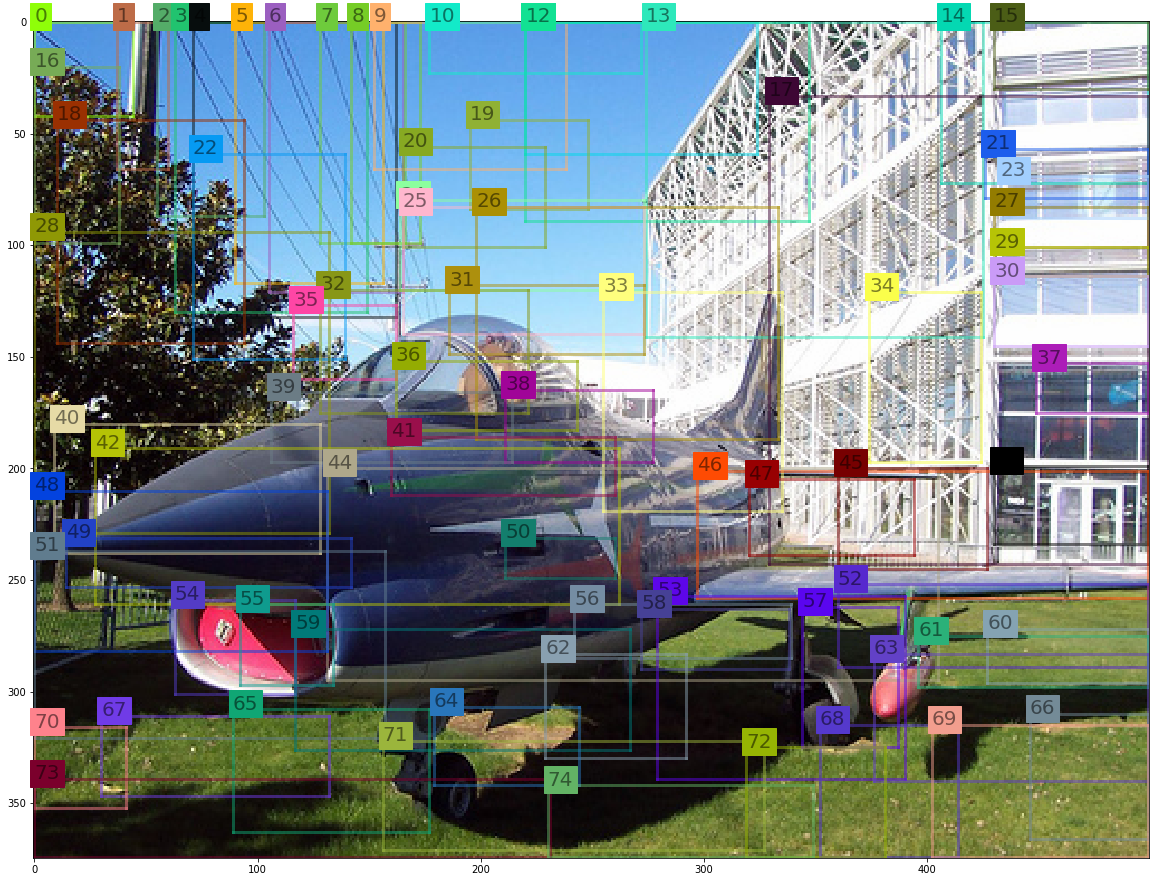

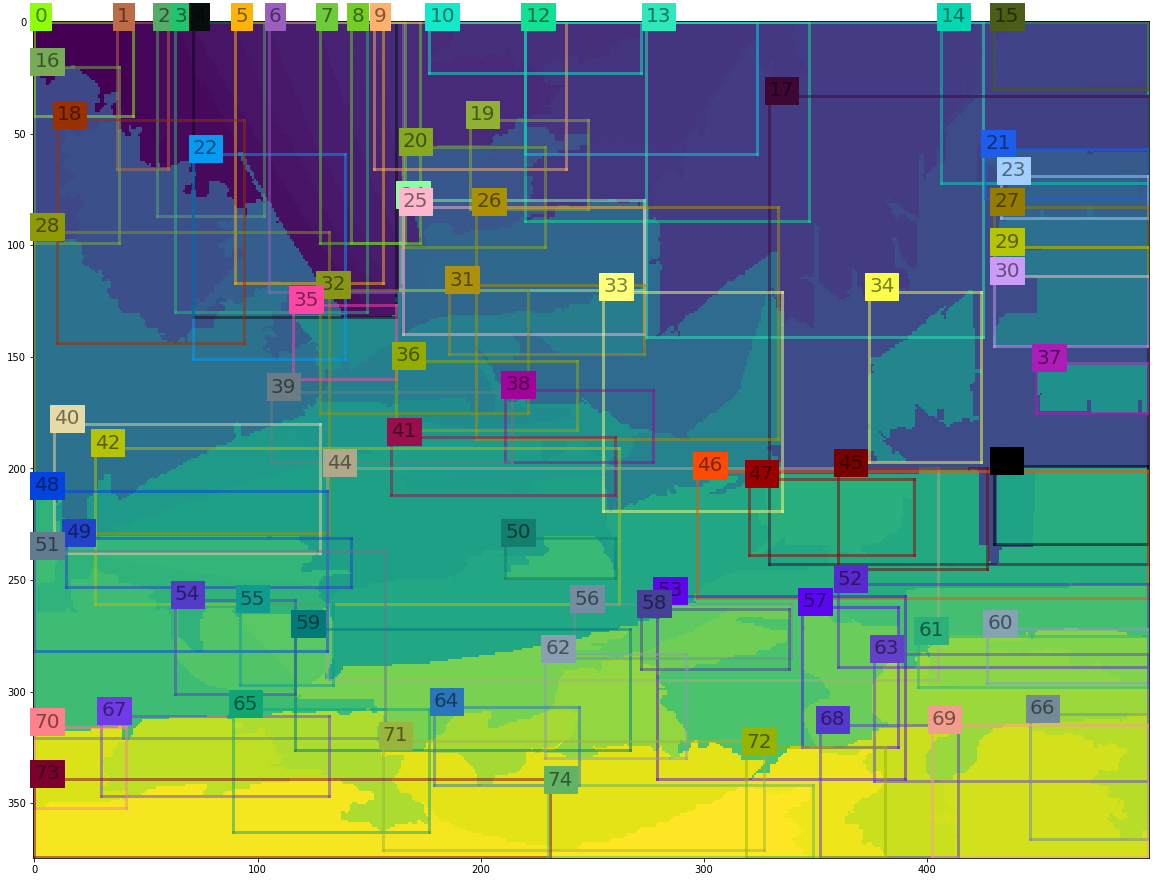

In [5]:
def plt_rectangle(plt,label,x1,y1,x2,y2,color = "yellow", alpha=0.5):
    linewidth = 3
    if type(label) == list:
        linewidth = len(label)*3 + 2
        label = ""
        
    plt.text(x1,y1,label,fontsize=20,backgroundcolor=color,alpha=alpha)
    plt.plot([x1,x1],[y1,y2], linewidth=linewidth,color=color, alpha=alpha)
    plt.plot([x2,x2],[y1,y2], linewidth=linewidth,color=color, alpha=alpha)
    plt.plot([x1,x2],[y1,y1], linewidth=linewidth,color=color, alpha=alpha)
    plt.plot([x1,x2],[y2,y2], linewidth=linewidth,color=color, alpha=alpha)

figsize = (20,20)
plt.figure(figsize=figsize)    
plt.imshow(img[:,:,:3]/2**8)
for item, color in zip(R.values(),sns.xkcd_rgb.values()):
    x1 = item["min_x"]
    y1 = item["min_y"]
    x2 = item["max_x"]
    y2 = item["max_y"]
    label = item["labels"][0]
    plt_rectangle(plt,label,x1,y1,x2,y2,color=color)
plt.show()

plt.figure(figsize=figsize)    
plt.imshow(img[:,:,3])
for item, color in zip(R.values(),sns.xkcd_rgb.values()):
    x1 = item["min_x"]
    y1 = item["min_y"]
    x2 = item["max_x"]
    y2 = item["max_y"]
    label = item["labels"][0]
    plt_rectangle(plt,label,x1,y1,x2,y2,color=color)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


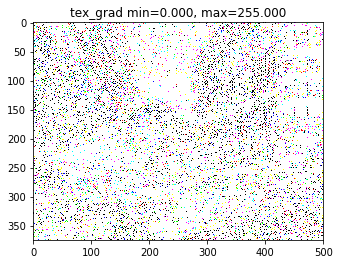

In [6]:
def calc_texture_gradient(img):
    """
        calculate texture gradient for entire image

        The original SelectiveSearch algorithm proposed Gaussian derivative
        for 8 orientations, but we use LBP instead.

        output will be [height(*)][width(*)]
    """
    ret = np.zeros(img.shape[:3])
    for colour_channel in (0, 1, 2):
        ret[:, :, colour_channel] = skimage.feature.local_binary_pattern(
            img[:, :, colour_channel], 8, 1.0)

    return ret


def plot_image_with_min_max(img,nm):
    img = img[:,:,:3]
    plt.imshow(img)
    plt.title("{} min={:5.3f}, max={:5.3f}".format(nm,
                                                   np.min(img),
                                                   np.max(img)))
    plt.show()

tex_grad = calc_texture_gradient(img)   
plot_image_with_min_max(tex_grad,nm="tex_grad")

/home/ali/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/home/ali/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/home/ali/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/home/ali/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:283: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


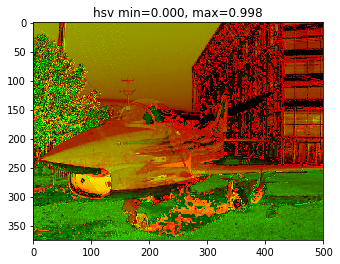

In [7]:
def calc_hsv(img):
    hsv = skimage.color.rgb2hsv(img[:,:,:3])
    return(hsv)

hsv = calc_hsv(img)
plot_image_with_min_max(hsv,nm="hsv")


In [9]:
def calc_hist(img, minhist=0, maxhist=1):
    """
        calculate colour histogram for each region

        the size of output histogram will be BINS * COLOUR_CHANNELS(3)

        number of bins is 25 as same as [uijlings_ijcv2013_draft.pdf]

        extract HSV
        
        len(hist) = BINS * 3
        hist[:BINS] = [0, 10, 20, 0,...,0] meaning that 
           there are 10 pixels that have values between (maxhist - minhist)/BINS*1 and (maxhist - minhist)/BINS*2
           there are 10 pixels that have values between (maxhist - minhist)/BINS*2 and (maxhist - minhist)/BINS*3
    
    """

    BINS = 25
    hist = np.array([])

    for colour_channel in range(3):

        # extracting one colour channel
        c = img[:, colour_channel]

        # calculate histogram for each colour and join to the result
        hist = np.concatenate(
            [hist] + [np.histogram(c, BINS, 
                                   # The lower and upper range of the bins. 
                                   (minhist, maxhist))[0]])

    # L1 normalize
    hist = hist / len(img)
    return hist

def augment_regions_with_histogram_info(tex_grad, img, R,hsv,tex_trad):
    for k, v in list(R.items()):

        ## height and width axies are flattened. 
        ## masked_pixel.shape = (N pixel with this mask ID , 3)
        masked_pixels  = hsv[img[:, :, 3] == k] 
        R[k]["size"]   = len(masked_pixels / 4)
        R[k]["hist_c"] = calc_hist(masked_pixels,minhist=0, maxhist=1)

        # texture histogram
        R[k]["hist_t"] = calc_hist(tex_grad[img[:, :, 3] == k],minhist=0, maxhist=2**8-1)
    return(R)
R = augment_regions_with_histogram_info(tex_grad, img,R,hsv,tex_grad)

In [10]:
def extract_neighbours(regions):
    '''
    check if two regions intersect 
    '''

    def intersect(a, b):
        if (a["min_x"] < b["min_x"] < a["max_x"] and a["min_y"] < b["min_y"] < a["max_y"]) or\
           (a["min_x"] < b["max_x"] < a["max_x"] and a["min_y"] < b["max_y"] < a["max_y"]) or\
           (a["min_x"] < b["min_x"] < a["max_x"] and a["min_y"] < b["max_y"] < a["max_y"]) or\
           (a["min_x"] < b["max_x"] < a["max_x"] and a["min_y"] < b["min_y"] < a["max_y"]):
            return True
        return False

    R = list(regions.items())
    neighbours = []
    for cur, a in enumerate(R[:-1]):
        for b in R[cur + 1:]:
            if intersect(a[1], b[1]):
                neighbours.append((a, b))

    return neighbours

neighbours = extract_neighbours(R)
print("Out of {} regions, we found {} intersecting pairs".format(len(R),len(neighbours)))

Out of 75 regions, we found 205 intersecting pairs


In [11]:
def _sim_colour(r1, r2):
    """
        calculate the sum of histogram intersection of colour
    """
    return sum([min(a, b) for a, b in zip(r1["hist_c"], r2["hist_c"])])


def _sim_texture(r1, r2):
    """
        calculate the sum of histogram intersection of texture
    """
    return sum([min(a, b) for a, b in zip(r1["hist_t"], r2["hist_t"])])


def _sim_size(r1, r2, imsize):
    """
        calculate the size similarity over the image
    """
    return 1.0 - (r1["size"] + r2["size"]) / imsize


def _sim_fill(r1, r2, imsize):
    """
        calculate the fill similarity over the image
    """
    bbsize = (
        (max(r1["max_x"], r2["max_x"]) - min(r1["min_x"], r2["min_x"]))
        * (max(r1["max_y"], r2["max_y"]) - min(r1["min_y"], r2["min_y"]))
    )
    return 1.0 - (bbsize - r1["size"] - r2["size"]) / imsize
def calc_sim(r1, r2, imsize):
    return (_sim_colour(r1, r2)       +\
            _sim_texture(r1, r2)      +\
            _sim_size(r1, r2, imsize) +\
            _sim_fill(r1, r2, imsize))

def calculate_similarlity(img,neighbours,verbose=False):
    # calculate initial similarities
    imsize = img.shape[0] * img.shape[1]
    S = {}
    for (ai, ar), (bi, br) in neighbours:
        S[(ai, bi)] = calc_sim(ar, br, imsize)
        if verbose:
            print("S[({:2.0f}, {:2.0f})]={:3.2f}".format(ai,bi,S[(ai, bi)]))
    return(S)

print("S[(Pair of the intersecting regions)] = Similarity index")
S = calculate_similarlity(img,neighbours,verbose=True)

S[(Pair of the intersecting regions)] = Similarity index
S[( 0, 16)]=6.13
S[( 1, 16)]=6.52
S[( 2, 18)]=6.10
S[( 2, 22)]=6.67
S[( 3,  5)]=7.51
S[( 3,  6)]=7.42
S[( 3,  7)]=7.22
S[( 3,  8)]=7.14
S[( 3, 18)]=5.99
S[( 3, 22)]=6.77
S[( 3, 28)]=5.86
S[( 3, 32)]=5.77
S[( 3, 35)]=5.78
S[( 4,  5)]=7.54
S[( 4,  6)]=7.49
S[( 4,  7)]=7.24
S[( 4,  8)]=7.15
S[( 4,  9)]=6.73
S[( 4, 18)]=6.07
S[( 4, 22)]=6.83
S[( 4, 28)]=5.96
S[( 4, 32)]=5.94
S[( 4, 35)]=5.92
S[( 5,  7)]=7.50
S[( 5,  8)]=7.44
S[( 5,  9)]=6.82
S[( 5, 18)]=5.94
S[( 5, 22)]=6.67
S[( 5, 28)]=5.86
S[( 6,  7)]=7.52
S[( 6,  8)]=7.51
S[( 6,  9)]=6.73
S[( 6, 22)]=6.69
S[( 6, 24)]=6.23
S[( 6, 28)]=5.91
S[( 6, 32)]=5.87
S[( 7,  9)]=6.74
S[( 7, 20)]=6.40
S[( 7, 22)]=6.31
S[( 7, 24)]=6.04
S[( 7, 25)]=5.63
S[( 7, 28)]=5.64
S[( 8,  9)]=6.65
S[( 8, 20)]=6.44
S[( 8, 24)]=6.10
S[( 8, 25)]=5.65
S[( 9, 10)]=7.40
S[( 9, 11)]=7.62
S[( 9, 19)]=7.01
S[( 9, 20)]=6.89
S[(11, 19)]=7.09
S[(11, 20)]=6.90
S[(12, 17)]=5.82
S[(12, 19)]=6.70
S[(12, 20)]=6.87
S[(12, 2

In [12]:
def merge_regions(r1, r2):
    '''
    Suppose r1 and r2 look like: 
    
    (minx1, miny1)
          _____________________
          |                   |
          |     (minx2,maxy2) |
          |           ________|____ 
          |          |        |    |
          |          |        |    |
          |          |________|____|(maxx2, maxy2)
          |___________________|(maxx1, maxy1)
          
    Then for merged region,
    
    minx : minx1
    miny : miny1
    maxx : maxx2
    maxy : maxy1 
    size : the number of pixels in the two regions (intersection is counted twice?)
    
                         
    '''
    new_size = r1["size"] + r2["size"]
    rt = {
        "min_x": min(r1["min_x"], r2["min_x"]),
        "min_y": min(r1["min_y"], r2["min_y"]),
        "max_x": max(r1["max_x"], r2["max_x"]),
        "max_y": max(r1["max_y"], r2["max_y"]),
        "size": new_size,
        "hist_c": (r1["hist_c"] * r1["size"] + r2["hist_c"] * r2["size"]) / new_size,
        "hist_t": (r1["hist_t"] * r1["size"] + r2["hist_t"] * r2["size"]) / new_size,
        "labels": r1["labels"] + r2["labels"]
    }
    return rt

def merge_regions_in_order(S,R,imsize, verbose=False):
    '''
    == Input ==
    S : similarity dictionary
    
    R : dictionary of proposed regions
    
    == Output ==
    
    regions : list of regions
    
    '''
    # hierarchal search
    while S != {}:

        # Step 1: get highest similarity pair of regions from the similarlity dictionary
        i, j = sorted(S.items(), key=lambda i: i[1])[-1][0]

        # Step 2: marge the region pair and add to the region dictionary
        t = max(R.keys()) + 1.0
        R[t] = merge_regions(R[i], R[j])

        # Step 3: from the similarity dictionary, 
        #         remove all the pair of regions where one of the regions is selected in Step 1
        key_to_delete = []
        for k, v in list(S.items()):
            if (i in k) or (j in k):
                key_to_delete.append(k)
        for k in key_to_delete:
            del S[k]

        # Step 4: calculate similarity with new merged region and the regions and its intersecting region
        #         (intersecting region is the region that are to be deleted)
        for k in key_to_delete:
            if k != (i,j):
                if k[0] in (i, j):
                    n = k[1]
                else:
                    n = k[0]
                S[(t, n)] = calc_sim(R[t], R[n], imsize)
    if verbose:
        print("{} regions".format(len(R)))

    ## finally return list of region proposal
    regions = []
    for k, r in list(R.items()):
            regions.append({
                'rect': (
                    r['min_x'],              # min x
                    r['min_y'],              # min y
                    r['max_x'] - r['min_x'], # width 
                    r['max_y'] - r['min_y']),# height
                'size': r['size'],
                'labels': r['labels']
            })
    return(regions)



regions = merge_regions_in_order(S,R,img.shape[0]*img.shape[1],verbose=True)

149 regions


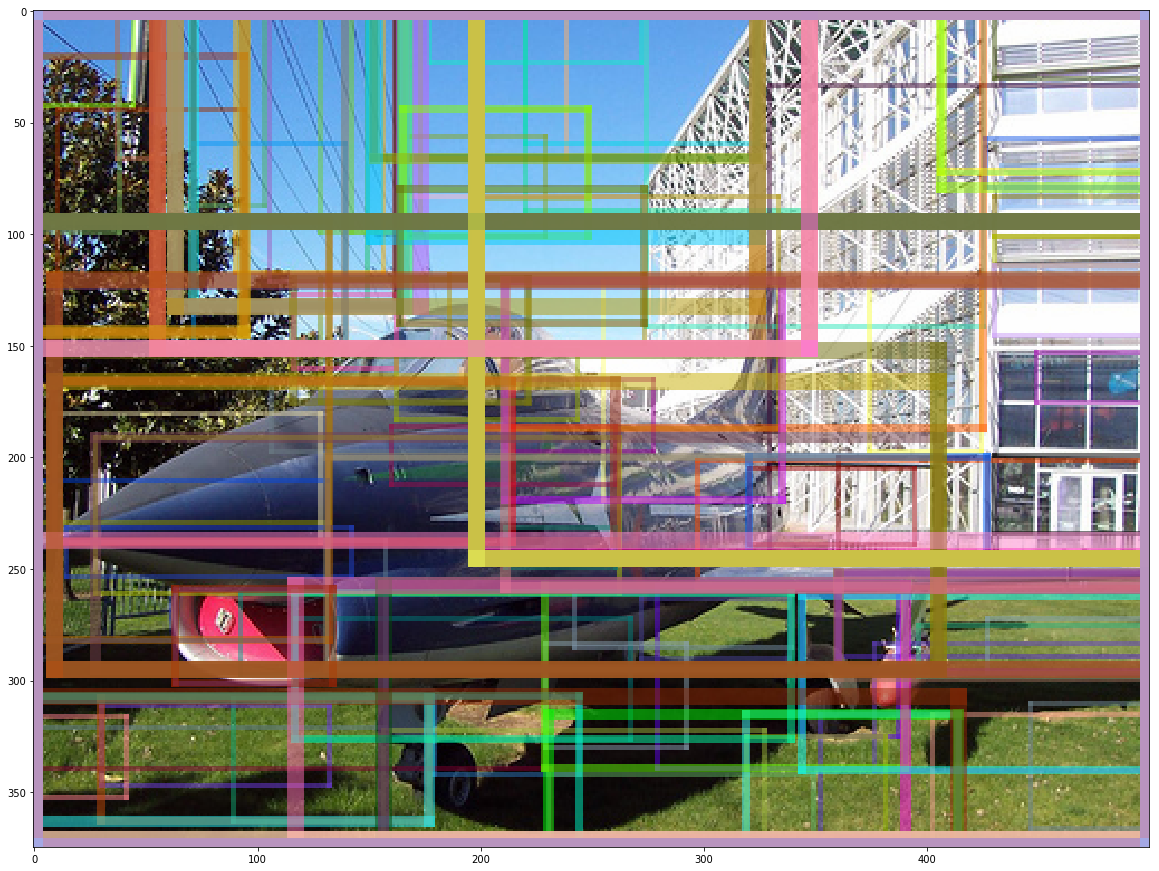

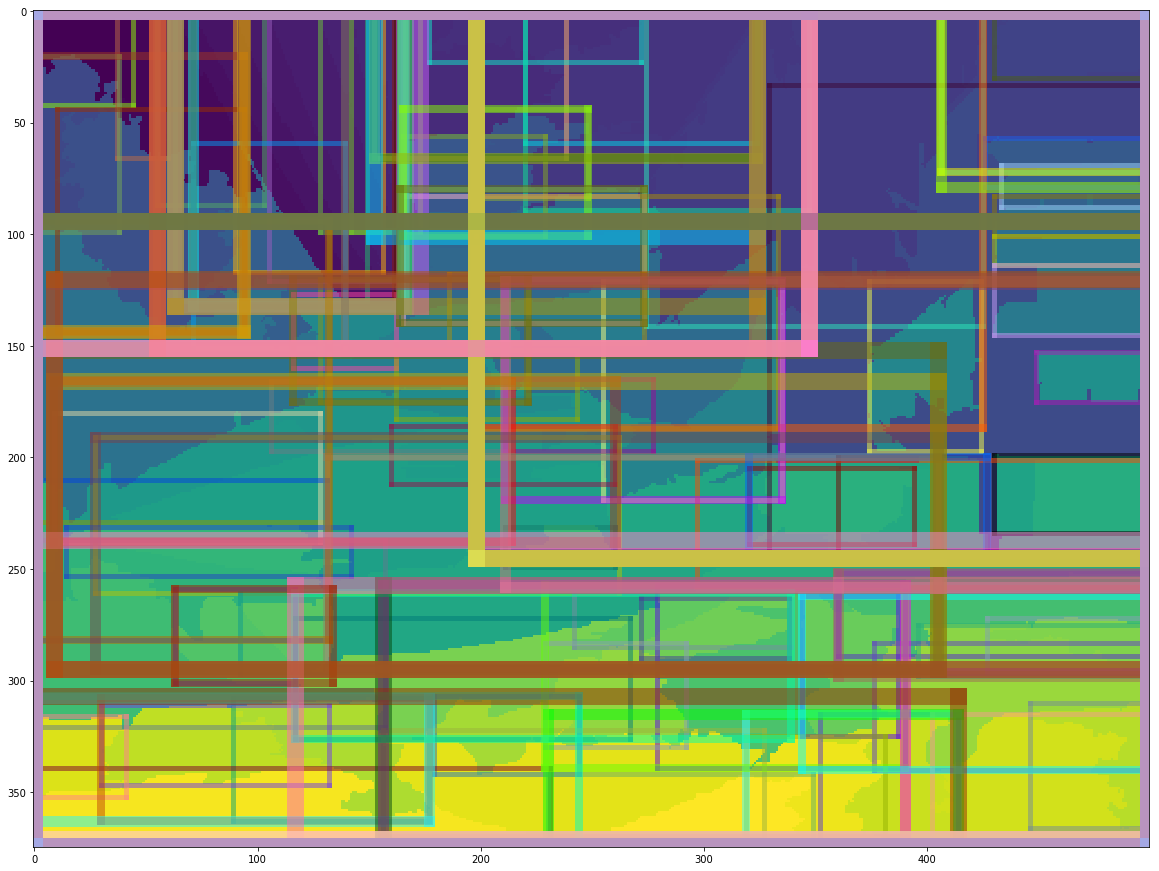

In [13]:
plt.figure(figsize=(20,20))    
plt.imshow(img[:,:,:3]/2**8)
for item, color in zip(regions,sns.xkcd_rgb.values()):
    x1, y1, width, height = item["rect"]
    label = item["labels"][:5]
    plt_rectangle(plt,label,x1,y1,x2 = x1 + width,y2 = y1 + height, color = color)
plt.show()

plt.figure(figsize=(20,20))    
plt.imshow(img[:,:,3])
for item, color in zip(regions,sns.xkcd_rgb.values()):
    x1, y1, width, height = item["rect"]
    label = item["labels"][:5]
    plt_rectangle(plt,label,
                  x1,
                  y1,
                  x2 = x1 + width,
                  y2 = y1 + height, color= color)
plt.show()

In [14]:
def get_region_proposal(img_8bit,min_size = 500):
    img        = image_segmentation(img_8bit,min_size = min_size)
    R          = extract_region(img)    
    tex_grad   = calc_texture_gradient(img)
    hsv        = calc_hsv(img)
    R          = augment_regions_with_histogram_info(tex_grad, img, R,hsv,tex_grad)
    del tex_grad, hsv
    neighbours = extract_neighbours(R)
    S          = calculate_similarlity(img,neighbours)
    regions    = merge_regions_in_order(S,R,imsize = img.shape[0] * img.shape[1])
    return(regions)
regions = get_region_proposal(img_8bit,min_size=500)

regions
print("{} regions are found".format(len(regions)))

149 regions are found


/home/ali/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


In [17]:
# location to save df_anno.csv
import pandas as pd

dir_preprocessed = "/home/ali/VOCdevkit/VOC2012_1500/"
df_anno = pd.read_csv(os.path.join(dir_preprocessed,"df_anno.csv"),low_memory=False)

In [18]:
cols_bbx = []
for colnm in df_anno.columns:
    if "name" in colnm:
        cols_bbx.append(colnm)
bbx_has_personTF = df_anno[cols_bbx].values == "person"
pick = np.any(bbx_has_personTF,axis=1)
df_anno_person = df_anno.loc[pick,:]

In [19]:
def get_IOU(xmin1,ymin1,xmax1,ymax1,
            xmin2,ymin2,xmax2,ymax2):
    '''
     
    (minx1, miny1)
          _____________________
          |                   |
          |     (minx2,maxy2) |
          |           ________|____ 
          |          |        |    |
          |          |        |    |
          |          |________|____|(maxx2, maxy2)
          |___________________|(maxx1, maxy1)
          
    
                         
    '''    
    def get_wha(xmin1,xmax1,ymin1,ymax1):
            width1  = xmax1 - xmin1
            height1 = ymax1 - ymin1
            area1   = width1 * height1
            return(width1,height1,area1)
    width1,height1,area1 = get_wha(xmin1,xmax1,ymin1,ymax1)
    width2,height2,area2 = get_wha(xmin2,xmax2,ymin2,ymax2)
            
    int_xmin   = np.max([xmin1,xmin2])
    int_ymin   = np.max([ymin1,ymin2])
    int_xmax   = np.min([xmax1,xmax2])
    int_ymax   = np.min([ymax1,ymax2])            
    int_width  = int_xmax - int_xmin
    int_height = int_ymax - int_ymin
    int_area   = int_width*int_height    
    
    if (int_width < 0) or (int_height < 0):
        IOU = 0
    else:
        IOU = int_area / float(area1 + area2 - int_area)
    return(IOU)

In [20]:
import time, imageio
            
start = time.time()            
person_found_vec = []
for irow in range(df_anno_person.shape[0]): ## run over each frame
    row  = df_anno_person.iloc[irow,:]
    path = os.path.join(img_dir,row["fileID"] + ".jpg")
    img  = imageio.imread(path)
    
    ## calculate region proposal
    regions = get_region_proposal(img,min_size=40)
    
    for ibb in range(row["Nobj"]): ## go over each of the true annotated object
        print("frameID = {:04.0f}/{}, BBXID = {},  N region proposals = {}".format(
            irow, df_anno_person.shape[0], ibb, len(regions)))
        name = row["bbx_{}_name".format(ibb)]
        if name != "person":
            continue 
        ## bounding box of the person     
        true_xmin   = row["bbx_{}_xmin".format(ibb)]
        true_ymin   = row["bbx_{}_ymin".format(ibb)]
        true_xmax   = row["bbx_{}_xmax".format(ibb)]
        true_ymax   = row["bbx_{}_ymax".format(ibb)]   
        person_found_TF = 0
        for r in regions:  ## go over each region proposal and calculate the IoU
            
            prpl_xmin, prpl_ymin, prpl_width, prpl_height = r["rect"]
            IoU = get_IOU(prpl_xmin, prpl_ymin, prpl_xmin + prpl_width, prpl_ymin + prpl_height,
                          true_xmin, true_ymin, true_xmax, true_ymax)
            if IoU > 0.5:
                person_found_TF = 1
        person_found_vec.append(person_found_TF)
end = time.time()  
print("TIME TOOK : {}MIN".format((end-start)/60))
print("Total N of person : {}, Total N of person found : {}, TPR: {:4.3f}".format(
    len(person_found_vec),
    np.sum(person_found_vec),
    np.mean(person_found_vec)))

/home/ali/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/home/ali/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:275: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = (arr[idx, 1] - arr[idx, 2]) / delta[idx]
/home/ali/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:279: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 2. + (arr[idx, 2] - arr[idx, 0]) / delta[idx]
/home/ali/anaconda3/lib/python3.7/site-packages/skimage/color/colorconv.py:283: RuntimeWarning: divide by zero encountered in true_divide
  out[idx, 0] = 4. + (arr[idx, 0] - arr[idx, 1]) / delta[idx]


frameID = 0000/863, BBXID = 0,  N region proposals = 2095
frameID = 0000/863, BBXID = 1,  N region proposals = 2095
frameID = 0000/863, BBXID = 2,  N region proposals = 2095


/home/ali/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


frameID = 0001/863, BBXID = 0,  N region proposals = 2472


/home/ali/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


frameID = 0002/863, BBXID = 0,  N region proposals = 2244
frameID = 0002/863, BBXID = 1,  N region proposals = 2244


/home/ali/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


frameID = 0003/863, BBXID = 0,  N region proposals = 1878
frameID = 0003/863, BBXID = 1,  N region proposals = 1878


/home/ali/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


frameID = 0004/863, BBXID = 0,  N region proposals = 2252


/home/ali/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


frameID = 0005/863, BBXID = 0,  N region proposals = 2444
frameID = 0005/863, BBXID = 1,  N region proposals = 2444


/home/ali/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


frameID = 0006/863, BBXID = 0,  N region proposals = 2327


/home/ali/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


frameID = 0007/863, BBXID = 0,  N region proposals = 2438
frameID = 0007/863, BBXID = 1,  N region proposals = 2438
frameID = 0007/863, BBXID = 2,  N region proposals = 2438


/home/ali/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


frameID = 0008/863, BBXID = 0,  N region proposals = 1873
frameID = 0008/863, BBXID = 1,  N region proposals = 1873


/home/ali/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


frameID = 0009/863, BBXID = 0,  N region proposals = 1999
frameID = 0009/863, BBXID = 1,  N region proposals = 1999
frameID = 0009/863, BBXID = 2,  N region proposals = 1999
frameID = 0009/863, BBXID = 3,  N region proposals = 1999
frameID = 0009/863, BBXID = 4,  N region proposals = 1999
frameID = 0009/863, BBXID = 5,  N region proposals = 1999
frameID = 0009/863, BBXID = 6,  N region proposals = 1999
frameID = 0009/863, BBXID = 7,  N region proposals = 1999
frameID = 0009/863, BBXID = 8,  N region proposals = 1999
frameID = 0009/863, BBXID = 9,  N region proposals = 1999


/home/ali/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


frameID = 0010/863, BBXID = 0,  N region proposals = 1734


/home/ali/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


frameID = 0011/863, BBXID = 0,  N region proposals = 2715
frameID = 0011/863, BBXID = 1,  N region proposals = 2715
frameID = 0011/863, BBXID = 2,  N region proposals = 2715
frameID = 0011/863, BBXID = 3,  N region proposals = 2715


/home/ali/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


frameID = 0012/863, BBXID = 0,  N region proposals = 2093
frameID = 0012/863, BBXID = 1,  N region proposals = 2093
frameID = 0012/863, BBXID = 2,  N region proposals = 2093


/home/ali/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


frameID = 0013/863, BBXID = 0,  N region proposals = 2055
frameID = 0013/863, BBXID = 1,  N region proposals = 2055
frameID = 0013/863, BBXID = 2,  N region proposals = 2055
frameID = 0013/863, BBXID = 3,  N region proposals = 2055
frameID = 0013/863, BBXID = 4,  N region proposals = 2055
frameID = 0013/863, BBXID = 5,  N region proposals = 2055
frameID = 0013/863, BBXID = 6,  N region proposals = 2055


/home/ali/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


frameID = 0014/863, BBXID = 0,  N region proposals = 2152
frameID = 0014/863, BBXID = 1,  N region proposals = 2152


/home/ali/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


frameID = 0015/863, BBXID = 0,  N region proposals = 2442
frameID = 0015/863, BBXID = 1,  N region proposals = 2442
frameID = 0015/863, BBXID = 2,  N region proposals = 2442
frameID = 0015/863, BBXID = 3,  N region proposals = 2442


/home/ali/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


KeyboardInterrupt: 

In [21]:
print("Total N of person : {}, Total N of person found : {}, TPR: {:4.3f}".format(
    len(person_found_vec),
    np.sum(person_found_vec),
    np.mean(person_found_vec)))

Total N of person : 29, Total N of person found : 19, TPR: 0.655
